# Part of Speech Tagging and Knowledge Graph Using Spacy

## 1. Introduction <a id="KG1"></a> <br>
Source: https://www.ibm.com/cloud/learn/knowledge-graph and https://www.kaggle.com/pavansanagapati/knowledge-graph-nlp-tutorial-bert-spacy-nltk <br>

### 1.1 What is part of speech tagging?
Part-of-speech (POS) tagging is a popular Natural Language Processing process which refers to categorizing words in a text (corpus) in correspondence with a particular part of speech, depending on the definition of the word and its context.
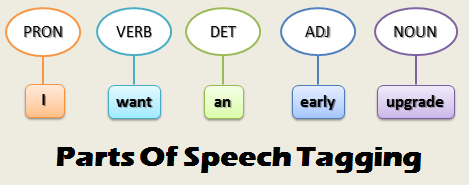
### 1.2 What is Knowledge Graph? <a id="KG11"></a> <br>

A knowledge graph, also known as a semantic network, represents a network of real-world entities—i.e. objects, events, situations, or concepts—and illustrates the relationship between them. This information is usually stored in a graph database and visualized as a graph structure, prompting the term knowledge “graph.”

A knowledge graph is made up of three main components: nodes, edges, and labels. Any object, place, or person can be a node. An edge defines the relationship between the nodes. For example, a node could be a client, like IBM, and an agency like, Ogilvy. An edge would be categorize the relationship as a customer relationship between IBM and Ogilvy. 

**We can define a graph as a set of nodes and edges.**
![](https://cdn.analyticsvidhya.com/wp-content/uploads/2019/10/graph_link.png)
Node A and Node B here are two different entities. These nodes are connected by an edge that represents the relationship between the two nodes. Now, this is the smallest knowledge graph we can build – it is also known as a **triple**.Knowledge Graph’s come in a variety of shapes and sizes. 

### 1.3 How Knowledge Graph works? <a id="KG12"></a> <br>
Knowledge graphs are typically made up of datasets from various sources, which frequently differ in structure. Schemas, identities and context work together to provide structure to diverse data. Schemas provide the framework for the knowledge graph, identities classify the underlying nodes appropriately, and the context determines the setting in which that knowledge exists. These components help distinguish words with multiple meanings. This allows products, like Google’s search engine algorithm, to determine the difference between Apple, the brand, and apple, the fruit.

Let's take this sentence as an example:

**London is the capital of England. Westminster is located in London.**

After some basic processing, we would 2 triples like this:

**(London, be capital, England), (Westminster, locate, London)**

So in this example we have three unique entities(London, England and Westminster) and two relations(be capital, locate). To build a knowledge graph, we only have two associated nodes in the graph with the entities and vertices with the relations and we will get something like this:
![](https://programmerbackpack.com/content/images/2020/01/Screenshot-2020-01-26-at-17.48.39.png)
Manually building a knowledge graph is not scalable. Nobody is going to go through thousands of documents and extract all the entities and the relations between them! That’s why machines are more suitable to perform this task as going through even hundreds or thousands of documents.

To build a knowledge graph from the text, it is important to make our machine understand natural language. This can be done by using NLP techniques such as sentence segmentation, dependency parsing, parts of speech tagging, and entity recognition. 

### 1.3 Import Dependencies & Load dataset and Basics of POS<a id="KG13"></a> <br>

In [15]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')
ner = spacy.load("en_core_web_sm", disable=["tok2vec", "tagger", "parser", "attribute_ruler", "lemmatizer"])

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [16]:
txt =''' 
New York (CNN Business)To comply with the Biden administration's upcoming vaccine mandate, Starbucks is requiring its workers to be fully vaccinated against Covid-19 or undergo weekly testing, the company recently told employees.

In a letter from Starbucks Chief Operating Officer John Culver, the coffee chain told its approximately 220,000 US employees they must disclose their vaccination status by January 10.
Although Starbucks strongly recommended employees get vaccinated, workers can choose not to get vaccinated and instead get tested weekly. They will be responsible for acquiring their own federally approved tests and submitting results.
"This is an important step we can take to help more partners get vaccinated, limit the spread of Covid-19, and create choices that partners can own based on what's best for them," Culver wrote. "If vaccination rates rise and community spread slows, we will adapt accordingly. But if things get worse, we may have to consider additional measures. For now, my hope is that we will all do our part to protect one another."
The changes come as the Occupational Safety and Health Administration recently set a new date of February 9 for large employers to require either full vaccinations or weekly testing as the Omicron variant spreads quickly throughout the United States.
Starbucks (SBUX) previously said it was "strongly encouraging" employees to get the vaccine and offered two hours of paid time off for each dose including the booster. It joins a number of employers requiring workers to show proof of a Covid-19 vaccine in order to comply with local laws in some places.
'''

In [17]:
txt=txt.replace("  ","").replace("_","").replace("\t","").strip()
candidate_sentences = pd.DataFrame(txt.split("\n"))
candidate_sentences.columns=['sentence']
candidate_sentences.shape

(7, 1)

In [18]:
import re
candidate_sentences['sentence']=candidate_sentences['sentence'].map(lambda x : re.sub('\d','',x.strip())).replace("")
candidate_sentences['sentence'].sample(5)

2                            In a letter from Starbucks Chief Operating Officer John Culver, the coffee chain told its approximately , US employees they must disclose their vaccination status by January .
1    New York (CNN Business)To comply with the Biden administration's upcoming vaccine mandate, Starbucks is requiring its workers to be fully vaccinated against Covid- or undergo weekly testing, the c...
5    The changes come as the Occupational Safety and Health Administration recently set a new date of February  for large employers to require either full vaccinations or weekly testing as the Omicron ...
4    "This is an important step we can take to help more partners get vaccinated, limit the spread of Covid-, and create choices that partners can own based on what's best for them," Culver wrote. "If ...
0    New York (CNN Business)To comply with the Biden administration's upcoming vaccine mandate, Starbucks is requiring its workers to be fully vaccinated against Covid- or undergo 

In [19]:
# Just picking any one sentence
chk = candidate_sentences['sentence'].sample(1).unique()[0]

doc_list = []
text = ner(chk)
for w in text.ents:
    print(w.text,w.label_)
spacy.displacy.render(text, style="ent",jupyter=True)

New York GPE
CNN ORG
Biden PERSON
Starbucks ORG
Covid- ORG
weekly DATE


In [20]:
# Part of Speech tagging
text2=nlp(chk)
options = {"compact": True, "font": "Source Sans Pro"}
spacy.displacy.render(text2, style="dep", options=options)

### 1.4 Sentence Segmentation <a id="KG14"></a> <br>
The first step in building a knowledge graph is to split the text document or article into sentences. Then, we will shortlist only those sentences in which there is exactly 1 subject and 1 object.

In [21]:
test="London is the capital of England. Westminster is located in London."
testList= test.split(".")
testList.remove("")
print(testList)

['London is the capital of England', ' Westminster is located in London']


In [22]:
doc = nlp(test)
for tok in doc:
  print(tok.text, ": ", tok.dep_)

print("---------------")
doc_list = []
text = ner(test)
for w in text.ents:
    print(w.text,w.label_)

London :  nsubj
is :  ROOT
the :  det
capital :  attr
of :  prep
England :  pobj
. :  punct
Westminster :  nsubjpass
is :  auxpass
located :  ROOT
in :  prep
London :  pobj
. :  punct
---------------
London GPE
England GPE
London GPE


### 1.5 Entities Extraction <a id="KG15"></a> <br>
The extraction of a single word entity from a sentence is not a tough task. We can easily do this with the help of parts of speech (POS) tags. The nouns and the proper nouns would be our entities.

However, when an entity spans across multiple words, then POS tags alone are not sufficient. We need to parse the dependency tree of the sentence.

To build a knowledge graph, the most important things are the nodes and the edges between them.

These nodes are going to be the entities. Edges are the relationships connecting these entities to one another. We will extract these elements in an unsupervised manner, i.e., we will use the grammar of the sentences.

The main idea is to go through a sentence and extract the subject and the object as and when they are encountered. However, there are a few challenges ⁠— an entity can span across multiple words, eg., “red wine”, and the dependency parsers tag only the individual words as subjects or objects.

In [23]:
#Source :https://www.kaggle.com/pavansanagapati/knowledge-graph-nlp-tutorial-bert-spacy-nltk
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

In [24]:
entity_pairs = []

for i in tqdm(testList):
  entity_pairs.append(get_entities(i))

100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 111.17it/s]


The list entity_pairs contains all the subject-object pairs from the Wikipedia sentences. Let’s have a look at a few of them:

In [25]:
entity_pairs 

[['London', 'England'], ['Westminster', 'London']]

As you can see, there are a few pronouns in these entity pairs such as ‘we’, ‘it’, ‘she’, etc. We’d like to have proper nouns or nouns instead. Perhaps we can further improve the get_entities( ) function to filter out pronouns

### 1.6 Relations Extraction <a id="KG16"></a> <br>
Entity extraction is half the job done. To build a knowledge graph, we need edges to connect the nodes (entities) to one another. These edges are the relations between a pair of nodes.

Our hypothesis is that the predicate is actually the main verb in a sentence.

For example, in the sentence – “Sixty Hollywood musicals were released in 1929”, the verb is “released in” and this is what we are going to use as the predicate for the triple generated from this sentence.

The function below is capable of capturing such predicates from the sentences. Here, we have used spaCy’s rule-based matching:

In [26]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [[{'DEP':'ROOT'}], [{'DEP':'prep'},{'OP':"?"}], [{'DEP':'agent'},{'OP':"?"}], [{'POS':'ADJ'},{'OP':"?"}]] 

  matcher.add("matching_1", pattern) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

The pattern defined in the function tries to find the ROOT word or the main verb in the sentence. Once the ROOT is identified, then the pattern checks whether it is followed by a preposition (‘prep’) or an agent word. If yes, then it is added to the ROOT word.
Let me show you a glimpse of this function:

In [27]:
relations = [get_relation(i) for i in tqdm(testList)]
relations

100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 111.17it/s]


['of England', 'in London']

Let’s take a look at the most frequent relations or predicates that we have just extracted:

In [28]:
pd.Series(relations).value_counts()[:50]

in London     1
of England    1
dtype: int64

### 1.7 Build Knowledge Graph <a id="KG17"></a> <br>

We will finally create a knowledge graph from the extracted entities (subject-object pairs) and the predicates (relation between entities).

Let’s create a dataframe of entities and predicates:

In [29]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

Next, we will use the networkx library to create a network from this dataframe. The nodes will represent the entities and the edges or connections between the nodes will represent the relations between the nodes.

It is going to be a directed graph. In other words, the relation between any connected node pair is not two-way, it is only from one node to another.

In [30]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

Let’s plot the network:

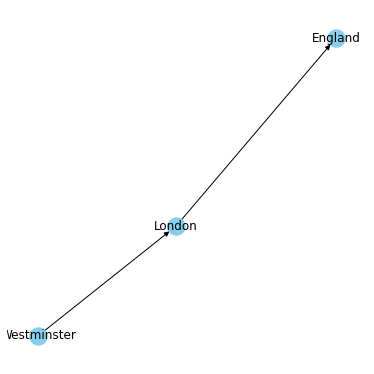

In [31]:
plt.figure(figsize=(5,5))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()